# Bag of Words (Мешок слов)

### Что такое NLP?
Обработка естественного языка - (Natural Language Processing, NLP ), представляет собой набор методов для решения задач по обработке текстов. В этом упражнениии, мы попробуем загрузить и почистить текст новостей, а затем, использую простую модель признаков - мешка слов (Bag of Words), научимся довольно точно предсказывать фэйковая это новость или настоящая.

Но для начала посмотрим как работает bag of words на игрушечном примере.

### Создаем особенности (features) из Bag of Words (Используя scikit-learn)
Теперь, когда у нас есть все данные, как их превратить в некоторое численное представление для машинного обучения? Один из таких подходов называется Мешком слов (Bag of Words). Модель Bag of Words изучает словарь из всех документов, затем моделирует каждый документ, подсчитывая количество раз, когда появляется каждое слово. Например, рассмотрим следующие два предложения:

Предложение 1: "The cat sat on the hat"

Предложение 2: "The dog ate the cat and the hat"

Для этих двух сообщений,получим следующий словарь:

{ the, cat, sat, on, hat, dog, ate, and }

Чтобы получить наш мешок слов, мы подсчитаем сколько раз каждое слово появилось в предложении. In В предложение 1, "the" появилось два раза, а "cat", "sat", "on", и "hat" по одному разу каждый. Поэтому вектор особенностей для этого предложения выглядит так:

{ the, cat, sat, on, hat, dog, ate, and }

{ 2, 1, 1, 1, 1, 0, 0, 0 }

Аналогично, особенности предложения 2 будут такими: { 3, 1, 0, 0, 1, 1, 1, 1}

В наших данных, очень много отзывов, что выльется в большой словарь. Чтобы ограничить размер вектора особенностей, выберем максимальный размер словаря. Пусть это будет 5000 слов (все стоп-слова и пунктуация из них уже убраны).

Мы будем использовать метод feature_extraction из модуля scikit-learn, чтобы создать мешок слов.

## Отступление: переводим текст в признаки

In [209]:
# создадим тренировочный список текстов
simple_train = ['call you tonight', 'Call me a cab', 'please call me.. please']

In [210]:
# 1. Импортируем и создадим модель CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [211]:
# обучаемся на данных
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [212]:
# Смотрим сгенерированные признаки
vect.get_feature_names()


['cab', 'call', 'me', 'please', 'tonight', 'you']

In [213]:
# преобразовываем исходный текст в матрицу признаков
simple_train_matrix = vect.transform(simple_train)
# каждый ряд - одно наблюдение (наш документ), каждая колонка - один признак (слово). 
# На пересечении - количество слов в документе.
simple_train_matrix

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [214]:
simple_train_matrix.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

*sparse matrix*

Разряженная матрица. Хранит только координаты ненулевых значений. Сильно экономит место. 

*dense matrix*

Плотная матрица. Хранит все данные.
Если у вас матрица 1000 на 1000 из нулей - она все это хранит (1 мб ничего).

In [215]:
pd.DataFrame(simple_train_matrix.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [216]:
print('sparse matrix')
print(simple_train_matrix)

print('dense matrix')
print(simple_train_matrix.toarray())

sparse matrix
  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2
dense matrix
[[0 1 0 0 1 1]
 [1 1 1 0 0 0]
 [0 1 1 2 0 0]]


In [217]:
# создадим текст для теста и преобразуем обученным CountVectorizer
simple_test = ['Please don\'t call me']
simple_test_matrix = vect.transform(simple_test)
simple_test_matrix.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [218]:
# куда делся don't?
pd.DataFrame(simple_test_matrix.toarray(), columns=vect.get_feature_names())


,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


Transform для тестовой выборки будет игнорировать токены, которые он не видел раньше (поэтому важен большой размер обучающей выборки и ее репрезентативность корпуса текстов).

### Стемминг (Stemming) и Лемматизация (Lemmatization)

Процесс Стемминга заключается в уменьшении различных вариантов одного и того же слова в одну общую форму. Например у нас есть слова "running", "runs" и "run", которые говорят об одном и том же, поэтому мы можем вмсто них использовать одно слово "run". Стоит отметить, что в этом случае мы можем потерять некоторые грамматические признаки, например форму времени.

Воспользуемся алгоритмом Портера из модуля NLTK. И покажем работу алгоритма на примере с вариантами слов run

In [74]:
stemmer = nltk.stem.PorterStemmer()

print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


Мы успешно обрезали наши слова до базовой формы.

Однако у стемминга есть тенденция к "грубому" обрезанию концов слов. Например, для leaves мы получим следующее:

In [75]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


С одной стороны это нормально, но базовой формой слова будет leaf. Поэтому на помощь нам приходит лемматизация.

Лемматизация пытается достигнуть того же эффекта, но в отличие от стеммера, лемматизация использует реальный словарь слов (Лемму) и поэтому не будет обрубать окончания слов.

Снова воспользуемся модулем NLTK и проверим, что он нам выдаст на leaves:

In [76]:
# Импортируем
from nltk.stem import WordNetLemmatizer
# Инициализируем 
lemm = WordNetLemmatizer()

print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


Получили верный ответ. Лемматизация обеспечивает нам более тонкую настройку по сравнению со стеммингом, но интергрирование лемматизации в функцию CountVectorizer() из sklearn, который мы будем пользоваться в дальнейшем требует некоторых танцев с бубном, поэтом в этот упражнении мы ее опустим.

# Are those news fake or real?
У нас есть датасет состоящий из заголовка новости, текста новости и лейбла, который показывает фейковая это новость или реальная.

Нашей задачей будет натренировать модель, чтобы она могла определить фейковая новость или реальная

### Загружаем данные

In [3]:
import pandas as pd 
 
data = pd.read_csv("fake_or_real_news.csv", header=0)

In [4]:
data.columns.values

array(['Unnamed: 0', 'title', 'text', 'label'], dtype=object)

Три основных столбца называются "title", "text", и "label".

Разделим наши данные на обучающую и тестовую выборки, чтобы потом можно было проверить насколько качественно работает наш алгоритм. За y обозначим наш лейбл. За X саму колонку с текстом новостей.

In [5]:
y = data['label']
X = data['text']

Для разделения данных на тестовую и обучающую выборки, воспользуемся функцией train_test_split из модуля sklearn. Как видно из названия она делит выборку на части и размещает данные по выбранным массивам. Test_size указывает на то, какую часть выборки нужно отложить для теста.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33,random_state=53)

Теперь, когда мы разбили данные и получили обучающую выборку, посмотрим как выглядит текст новости. Выведем любую новость

In [7]:
print(X_train.values[4])

Wells Fargo is Rotting from the Top Down Wells Fargo is Rotting from the Top Down By 0 139 
Just when you thought that, surely, big banker greed had bottomed out with 2008’s Wall Street crash and bailout, along comes Wells Fargo, burrowing even deeper into the ethical slime to reach a previously unimaginable level of corporate depravity. 
It’s one thing for these finance giants to cook the books or defraud investors, but top executives of Wells Fargo have been profiteering for years by literally forcing their employees to rob the bank’s customers. 
Rather than a culture of service, executives have pushed a high-pressure sales culture since 2009, demanding frontline employees meet extreme quotas of selling a myriad of unnecessary bank products to common depositors who just wanted a simple checking account. (Photo: Shutterstock) 
Employees were expected to load each customer with at least eight accounts, and employees were monitored constantly on meeting their quota — fail and you’d be f

Внутри текста мы можем иногда увидить HTML тэги (например "br"), аббревиатуры, пунктуацию, которые являются распространенными проблемы при обработке текста из Интернета.

### Чистка данных и предварительная обработка текста
Уберем разметку HTML: используем модуль BeautifulSoup

In [8]:
# Импортируем BeautifulSoup
from bs4 import BeautifulSoup             

# Инициализируем объект BeautifulSoup одним отзывом    
example1 = BeautifulSoup(X_train.values[4])  

print(example1.get_text())

Wells Fargo is Rotting from the Top Down Wells Fargo is Rotting from the Top Down By 0 139 
Just when you thought that, surely, big banker greed had bottomed out with 2008’s Wall Street crash and bailout, along comes Wells Fargo, burrowing even deeper into the ethical slime to reach a previously unimaginable level of corporate depravity. 
It’s one thing for these finance giants to cook the books or defraud investors, but top executives of Wells Fargo have been profiteering for years by literally forcing their employees to rob the bank’s customers. 
Rather than a culture of service, executives have pushed a high-pressure sales culture since 2009, demanding frontline employees meet extreme quotas of selling a myriad of unnecessary bank products to common depositors who just wanted a simple checking account. (Photo: Shutterstock) 
Employees were expected to load each customer with at least eight accounts, and employees were monitored constantly on meeting their quota — fail and you’d be f

Вызывая get_text(), мы получим полный текст отзыва, но без тегов или разметки (если они были)

Пунктуацию, числа и стоп-слова можно убрать с помощью NLTK и регулярных выражений.
Когда мы очищаем текст, нужно сначала подумать о том какую задачу мы решаем. Для многих задач есть смысл в том, чтобы убрать пунктуацию. С другой стороны, мы решаем задачу анализа настроений (sentiment) и есть вероятность, что "!!!" или ":-(" может нести в себе какое-то настроение и должно считаться словом. В этом задании, мы убираем пунктуацию, но в качестве эксперимента вы можете ее оставить и посмотреть как это повлияет на финальный результат.

Аналогично мы уберем числа, но обычно,тут также есть различные варианты как с ними можно поступить в зависимости от ситуации. Например, мы их можем считать словами или заменять их плейсхолдером "NUM".

Чтобы убрать пунктуацию и числа, воспользуемся модулем re, который позволяет нам использовать регулярные выражения:

In [9]:
import re
# воспользуемя регулярным выражениями чтобы найти и заменить
letters_only = re.sub("[^a-zA-Z]",           # Шаблон, который мы ищем - a-zA-Z - все буквы. 
                                             # ^ - отменяет выражение. Т.е. ищем ВСЕ КРОМЕ букв.
                      " ",                   # Шаблон, на который мы меняем (пробел в данном случае)
                      example1.get_text() )  # Текст,в котором мы ищем
print(letters_only)

Wells Fargo is Rotting from the Top Down Wells Fargo is Rotting from the Top Down By        Just when you thought that  surely  big banker greed had bottomed out with      s Wall Street crash and bailout  along comes Wells Fargo  burrowing even deeper into the ethical slime to reach a previously unimaginable level of corporate depravity   It s one thing for these finance giants to cook the books or defraud investors  but top executives of Wells Fargo have been profiteering for years by literally forcing their employees to rob the bank s customers   Rather than a culture of service  executives have pushed a high pressure sales culture since       demanding frontline employees meet extreme quotas of selling a myriad of unnecessary bank products to common depositors who just wanted a simple checking account   Photo  Shutterstock   Employees were expected to load each customer with at least eight accounts  and employees were monitored constantly on meeting their quota   fail and you d be f

Работа с регулярными выражениями не объясняется в этом задании, но [] означает группу символомов и ^ означает "не". Другими словами, выражение re.sub() означает следующее, "Найди все что НЕ является буквами нижнего регистра (a-z) или буквами верхнего регистра (A-Z), и замени их пробелом "

Мы также переведем все слова в нижний регистр и разделим текст на индивидуальнын слова, называемые токенами на языке NLP:

In [10]:
lower_case = letters_only.lower()        # Конвертируем в нижний регистр
words = lower_case.split()               # Разбиваем на слова (токены)

Наконец, нам нужно решить, что делать с часто встречающимися словами, которые не несут большого значения. Такие слова называются "стоп-словами"; в Английском языке это такие слова, как "a", "and", "is", и "the". Удобно, что в Питоне есть встроенный модуль по работе со стоп-словами. Давайте импортируем список стоп-слов из модуля Natural Language Toolkit (NLTK). Помимио самого модуля, нужно еще установить пакеты слов:

In [11]:
import nltk
nltk.download("stopwords")  
# Скачиваем нужные нам наборы. Необязательно скачивать все. Нам пока что нужен только
# corpora stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rogovich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Теперь мы можем использовать nltk для получения списка стоп-слов:

In [15]:
from nltk.corpus import stopwords # Импортируем список стол-слов
print(stopwords.words("english")) # Стоп-слова для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [204]:
print(stopwords.words("russian")) # Стоп-слова для русского языка

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

Чтобы убрать стоп-слова из нашей новости, сделаем так:

In [16]:
# Убираем стоп-слова из "words"
words = [w for w in words if not w in stopwords.words("english")]
print(words)

['wells', 'fargo', 'rotting', 'top', 'wells', 'fargo', 'rotting', 'top', 'thought', 'surely', 'big', 'banker', 'greed', 'bottomed', 'wall', 'street', 'crash', 'bailout', 'along', 'comes', 'wells', 'fargo', 'burrowing', 'even', 'deeper', 'ethical', 'slime', 'reach', 'previously', 'unimaginable', 'level', 'corporate', 'depravity', 'one', 'thing', 'finance', 'giants', 'cook', 'books', 'defraud', 'investors', 'top', 'executives', 'wells', 'fargo', 'profiteering', 'years', 'literally', 'forcing', 'employees', 'rob', 'bank', 'customers', 'rather', 'culture', 'service', 'executives', 'pushed', 'high', 'pressure', 'sales', 'culture', 'since', 'demanding', 'frontline', 'employees', 'meet', 'extreme', 'quotas', 'selling', 'myriad', 'unnecessary', 'bank', 'products', 'common', 'depositors', 'wanted', 'simple', 'checking', 'account', 'photo', 'shutterstock', 'employees', 'expected', 'load', 'customer', 'least', 'eight', 'accounts', 'employees', 'monitored', 'constantly', 'meeting', 'quota', 'fail'

Метод ищет каждое стоп-слово в списке наших слов "words", и удаляет если это слово есть.

Есть множество других полезных вещей, которые мы можем сделать с нашими данными, например, Porter Stemming и Lemmatizing (оба есть в NLTK) позволят нам рассматривать слова "messages", "message", и "messaging" как одно слово, что может быть очень полезно.

### Объединяем все вместе
Теперь у нас есть полный код, чтобы отчистить новость от всего лишнего. Запишем его в функцию для удобства обработки большого количества новостей:

In [17]:
def news_to_words( raw_news ):
    #
    # 1. Убираем HTML
    news_text = BeautifulSoup(raw_news).get_text() 
    #
    # 2. Оставляем только буквы       
    letters_only = re.sub("[^a-zA-Z]", " ", news_text) 
    #
    # 3. Переводим в нижний регистр и разбиваем на токены
    words = letters_only.lower().split()                             
    #
    # 4. В Питоне поиск в множествах (set) быстрее чем поиск в
    #   списках, конвертируем список стоп-слов в множество
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Убираем стоп-слова
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Объединяем все слова вместе в одну строчку, разделяя слова пробелом, 
    # и возвращаем результат
    return( " ".join( meaningful_words ))   

В этой функции есть два новых элемента. Во-первых, мы конвертировали список стоп-слов в другой тип данных - множество. Это сделано для ускорения, т.к. мы будем вызывать эту функцию десятки тысяч раз, и она должна работать быстро, а поиск в множествах гораздо быстрее в Питоне, чем поиск в списках.

Во-вторых, мы объединили все слова в один параграф. Это сделает вывод слов более удобным для функции Bag of Words. Вызывем функцию и проверим на нашем новости.

In [18]:
clean_news = news_to_words(X_train.values[4])
print(clean_news)

wells fargo rotting top wells fargo rotting top thought surely big banker greed bottomed wall street crash bailout along comes wells fargo burrowing even deeper ethical slime reach previously unimaginable level corporate depravity one thing finance giants cook books defraud investors top executives wells fargo profiteering years literally forcing employees rob bank customers rather culture service executives pushed high pressure sales culture since demanding frontline employees meet extreme quotas selling myriad unnecessary bank products common depositors wanted simple checking account photo shutterstock employees expected load customer least eight accounts employees monitored constantly meeting quota fail fired bosses sales culture turned employees syndicate bank robbers thievery systemic subtle half million customers secretly issued credit debit cards request fake email accounts online services set without customers knowledge depositors money moved one account another signatures forg

Мы должны получить точно такой же ответ, как и в варианте когда мы делали все преобразования без функции. Теперь пройдем циклом по всей обучающей выборке( это может занять некоторое время, в зависимости от мощности вашего компьютера):

In [20]:
print("Cleaning and parsing the training set news texts...\n")
# Инициализируем пустой список для хранения наших "чистых" новостей
clean_train_news = []

# Идем циклом по каждому отзыву
for i in range( 0, X_train.values.size ):
    # Если индекс делится нацело на 1000, то выводим сообщение
    if( (i+1)%1000 == 0 ):
        print("News %d of %d\n" % ( i+1, X_train.values.size )) 
    # Вызываем нашу функцию очищения на каждый отзыв и складываем результат
    # в список clean reviews
    clean_train_news.append( news_to_words( X_train.values[i]) )

Cleaning and parsing the training set news texts...

News 1000 of 4244

News 2000 of 4244

News 3000 of 4244

News 4000 of 4244



# Продолжим с новостями

In [22]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Инициализируем объект "CountVectorizer", метод для работы с bag of words
# из scikit-learn
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) # ограничиваем максимальное
                                # количество слов-признаков для ускорения
                                # работы алгоритма. Если не ограничивать -
                                # количество признаков будет равно всем
                                # уникальным словам в нашем корпусе выборки

# fit_transform() делает две вещи: Сначала он фитит модель
# и изучает словарь; Потом трансформирует нашу обучающую выборку
# в вектор особенностей. В fit_transform мы передаем список слов
train_data_features = vectorizer.fit_transform(clean_train_news)

# Используем удобные массивы из Numpy
train_data_features = train_data_features.toarray()

Creating the bag of words...



Посмотрим как выглядят наши обучающие данные:

In [23]:
print(train_data_features.shape)

(4244, 5000)


В ней 4244 строк и 5,000 особенностей (по одной на каждое слово в словаре).

Стоит отметить, что CountVectorizer идет со встроенными опциями по автоматическому препроцессингу, токенезации и удаленю стоп-слов -- для каждой из этих опций, мы могли вместо "None", использовать встроенные методы или указать свою функцию, которая это сделает.

Теперь наша модель Bag of Words натренирована, посмотрим на получившийся словарь:

In [24]:
vocab = vectorizer.get_feature_names()
print(vocab)

['abandon', 'abandoned', 'abc', 'abdullah', 'abedin', 'ability', 'able', 'abortion', 'abortions', 'abroad', 'absence', 'absolute', 'absolutely', 'absurd', 'abuse', 'academic', 'academy', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accompanied', 'accomplish', 'accomplished', 'according', 'account', 'accountability', 'accountable', 'accounts', 'accurate', 'accusations', 'accuse', 'accused', 'accusing', 'achieve', 'achieved', 'acknowledge', 'acknowledged', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'actively', 'activist', 'activists', 'activities', 'activity', 'actor', 'actors', 'acts', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'addresses', 'addressing', 'adds', 'administration', 'administrations', 'admiral', 'admit', 'admits', 'admitted', 'adopt', 'adopted', 'ads', 'adult', 'adults', 'advance', 'advanced', 'advances', 'advantage', 'advertisement', 'a

Дополнительно, можно вывести сколько раз слово встречается в словаре:

In [25]:
import numpy as np

# Подсчитаем количество слов в наших данных
dist = np.sum(train_data_features, axis=0)

# Выведем для каждого слова его количество
for tag, count in zip(vocab, dist):
    print(count, tag)

57 abandon
80 abandoned
205 abc
69 abdullah
232 abedin
424 ability
859 able
398 abortion
58 abortions
145 abroad
76 absence
93 absolute
282 absolutely
60 absurd
164 abuse
84 academic
64 academy
300 accept
78 acceptable
71 acceptance
151 accepted
71 accepting
598 access
63 accompanied
61 accomplish
63 accomplished
2088 according
413 account
91 accountability
109 accountable
194 accounts
90 accurate
128 accusations
63 accuse
345 accused
84 accusing
134 achieve
91 achieved
97 acknowledge
176 acknowledged
977 across
1112 act
62 acted
164 acting
826 action
529 actions
193 active
107 actively
161 activist
331 activists
217 activities
241 activity
56 actor
61 actors
191 acts
270 actual
1161 actually
223 ad
87 adam
266 add
854 added
334 adding
265 addition
259 additional
75 additionally
557 address
134 addressed
75 addresses
96 addressing
148 adds
1503 administration
54 administrations
108 admiral
103 admit
62 admits
163 admitted
75 adopt
95 adopted
137 ads
67 adult
119 adults
196 advance
109 

### Случайный лес (Random Forest)
В данный момент у нас есть численные значения признаков из обучающей выборки из Bag of Words и оригинальные лейблы новости, поэтому займемся обучением с учителем. Мы будем использовать классификатор Random Forest. Этот алгоритм включен в scikit-learn. Ниже мы указываем количество деревьев в 100 штук. Больше деревьев может улучшить (или не улучшить) результат, но в любом случае булет исполняться дольше. Аналогично, чем больше признаков будет для каждой новости, тем больше времени это займет.

In [26]:
print("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier

# Инициализируем Random Forest classifier 100 деревьями
forest = RandomForestClassifier(n_estimators = 100) 

# Обучаем лес на нашей обучающей выборке
forest = forest.fit( train_data_features, y_train)

Training the random forest...


C:\Users\rogovich\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Делаем предсказывание
Осталось только запустить подготовленный Random Forest на нашей тестовой выборке и проверить результаты предсказания.

Стоит отметить, что для тестовой выборки мы уже используем метод "transform", а не "fit_transform" в Bag of Words.

Но для начала преобразуем нашу тестовую выборку в bag of words.

In [27]:
# Создадим пустой список для хранения "чистых" отзывов
clean_test_news = [] 

print ("Cleaning and parsing the test set news texts...\n")
for i in range(0, len(X_test.values)):
    if( (i+1) % 1000 == 0 ):
        print ("News %d of %d\n" % (i+1,  len(X_test.values)))
    clean_news = news_to_words( X_test.values[i])
    clean_test_news.append( clean_news )

# Конвертируем получившиеся bag of words в массив Numpy
test_data_features = vectorizer.transform(clean_test_news)
test_data_features = test_data_features.toarray()

# Делаем предсказание нашим Random Forest
result = forest.predict(test_data_features)

Cleaning and parsing the test set news texts...

News 1000 of 2091

News 2000 of 2091



Теперь проверим насколько точно были предсказания.

In [28]:
from sklearn import metrics

metrics.accuracy_score(y_test, result)

0.9014825442372071

90% - Отличный результат.

Посмотрим какие признаки повлияли на наш результат. Получим список важности для признаки. Алгоритм случайного леса устроен так, что во время своей работы он выбирает наиболее важные признаки с его точки зрения (важные они, потому что удачнее всего разбивают выборку). Подробнее о случайном лесе было на прошлом семинаре.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_

Обработаем их и отсортируем по убыванию. Получим также имена наших особенностей

In [36]:
#индексы для сортировки признаков по убыванию от наиболее важного
indices = np.argsort(importances)[::-1]
#название признаков из нашего векторайзера
feature_names = vectorizer.get_feature_names()

Выведем 30 самых важных

In [37]:
print("Feature ranking:")

for f in range(30): 
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature said (0.017598)
2. feature october (0.010440)
3. feature sen (0.008906)
4. feature republicans (0.008722)
5. feature candidates (0.007960)
6. feature obama (0.007885)
7. feature president (0.007262)
8. feature nomination (0.007049)
9. feature cruz (0.006983)
10. feature senate (0.006455)
11. feature republican (0.006392)
12. feature com (0.006165)
13. feature gop (0.005880)
14. feature week (0.005322)
15. feature rubio (0.005237)
16. feature fox (0.005051)
17. feature conservative (0.004705)
18. feature monday (0.004468)
19. feature debate (0.004387)
20. feature contributed (0.004329)
21. feature hillary (0.004071)
22. feature convention (0.003858)
23. feature cnn (0.003856)
24. feature tuesday (0.003800)
25. feature primary (0.003648)
26. feature share (0.003604)
27. feature washington (0.003572)
28. feature house (0.003463)
29. feature article (0.003347)
30. feature two (0.003322)


Как мы видим, самая первая особенность очень важна, остальные постепено утрачивают своб значимость.
Теперь отобразим важности на гистограмме. Чтобы улучшить график - нужно вывести еще названия признаков по шкале x.

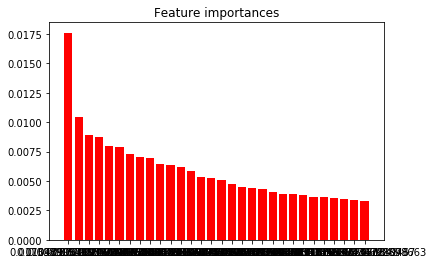

In [38]:
p = X_train.values
i = importances[indices]
plt.figure()
plt.title("Feature importances")
plt.bar(p[:30],i[:30], color="r", align="center")
plt.xticks(p[:30], i[:30])
plt.show()

# CountVectorizer

Попробуем натренировать модель без нашей функции по очищению текста и полностью довериться CountVectorizer.

Классификатор CountVectorizer вернет нам список токенов и количество их появлений в обучающей выборке. 

In [48]:
count_vectorizer = CountVectorizer(stop_words='english')

Теперь сделаем фит обучающей и тестовой выборок

In [49]:
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

Посмотрим что попало в словарь

In [41]:
count_vectorizer.vocabulary_

{'report': 42470,
 'copyright': 12105,
 'violation': 54177,
 'think': 50628,
 'doom': 15924,
 'sayers': 44520,
 'trump': 51896,
 'office': 35783,
 'notice': 35256,
 'glp': 21881,
 'republican': 42534,
 'bush': 8399,
 'left': 29531,
 'doomsaying': 15927,
 'increases': 25686,
 'sure': 49203,
 'effect': 16814,
 'opposite': 36087,
 'gets': 21568,
 'increase': 25684,
 'political': 38823,
 'spectrum': 47506,
 'page': 36831,
 'election': 16972,
 '232': 762,
 'photos': 38140,
 '43': 1127,
 'numbers': 35403,
 '131': 229,
 'quotes': 40794,
 'candidates': 8779,
 'center': 9445,
 'email': 17139,
 'wonder': 55615,
 'mind': 32729,
 'today': 51050,
 'notable': 35236,
 'people': 37695,
 'don': 15867,
 'miss': 32983,
 'unbelievable': 52435,
 'roundup': 43680,
 'best': 6494,
 'talked': 49772,
 'day': 13519,
 'course': 12424,
 'schindler': 44691,
 'list': 30107,
 'saddest': 44042,
 'movies': 33689,
 'time': 50906,
 'going': 21981,
 'brag': 7659,
 'chance': 9616,
 'liam': 29814,
 'neeson': 34495,
 'humili

### TfidfVectorizer

В больших текстах, некоторые слова могут встречаться очень часто (например “the”, “a”, “is” в Английском) при этом неся мало информации об истинном содержании текста. Поэтому мы можем добавить веса словами.

Tf-idf означает "frequency-inverse document frequency" (частотно-обратная частота документа) и представляет собой статистическую меру, используемую для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции. 

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

https://ru.wikipedia.org/wiki/TF-IDF

Используем Tfidvectorizer для конвертации данных в веса tfidf.

In [50]:
# Импортируем TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализируем объект TfidfVectorizer: tfidf_vectorizer
# А также ограничили выдачу слов, которые мало встречаются в текстах, 
# использовав параметр max_df
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)

Натренируем на тех же тестовых данных, что и CountVectorizer

In [57]:
# Тренируем классификатор
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

tfidf_test = tfidf_vectorizer.transform(X_test)

Посмотрим что получили

In [52]:
# Выведем 10 первых особеннойстей
print(tfidf_vectorizer.get_feature_names()[:5])

# Выведем первые 5 векторов обучающей выборки
print(tfidf_train.A[:5])


['00', '000', '0000', '00000031', '000035']


MemoryError: 

Пока что эти слова не встречаются в текстах, мы когда инициировали наш классификатор указали, чтобы он не учитывал слова, которые встречаются очень редко. Поэтому он им и поставил 0. Стоить также упомянуть, что матрицы могут быть очень разряженными.
Посмотрим, какие данные у нас где-нибудь в середине таблицы.

In [53]:
print(tfidf_vectorizer.get_feature_names()[3000:3020])

['alabaster', 'aladdin', 'alain', 'alam', 'alamein', 'alamogordo', 'alamos', 'alan', 'alancar', 'alani', 'alarabiya', 'alarm', 'alarmed', 'alarming', 'alarmingly', 'alarmism', 'alarmist', 'alarmists', 'alarms', 'alas']


### Сравнение векторов

Разместим оба наших вектора в Датафреймы

In [58]:
# Создадим Датафрейм для CountVectorizer: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Создадим Датафрейм для TfidfVectorizer: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns = tfidf_vectorizer.get_feature_names())


MemoryError: 

Посмотрим первые несколько элементов

In [55]:
print(count_df.head())

print(tfidf_df.head())

   00  000  0000  00000031  000035  00006  0001  0001pt  000ft  000km  ...    \
0   0    0     0         0       0      0     0       0      0      0  ...     
1   0    0     0         0       0      0     0       0      0      0  ...     
2   0    0     0         0       0      0     0       0      0      0  ...     
3   0    0     0         0       0      0     0       0      0      0  ...     
4   0    0     0         0       0      0     0       0      0      0  ...     

   حلب  عربي  عن  لم  ما  محاولات  من  هذا  والمرضى  ยงade  
0    0     0   0   0   0        0   0    0        0      0  
1    0     0   0   0   0        0   0    0        0      0  
2    0     0   0   0   0        0   0    0        0      0  
3    0     0   0   0   0        0   0    0        0      0  
4    0     0   0   0   0        0   0    0        0      0  

[5 rows x 56922 columns]


NameError: name 'tfidf_df' is not defined

Размерности этих двух таблиц идентичны. Различаются они только наполнением. Абсолютные значения (сколько слово встречается в тексте) для CountVectorizer и метрика частоты встречания (tf idf).

### Naive Bayes classifier

Воспользуемся Naive Bayes classifier для определения точности нашего предсказания. Он работает примерно так: "если слово "инпопланетяне" есть в тексте новости, то с какой вероятостью эта новость будет фейковой?". Делаем предсказания уже на тестовой выборке и смотрим насколько точно предсказание.

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
nb_classifier = MultinomialNB()

Будем использовать MultinomialNB(), потому что он хорошо работает с целыми числами.

Теперь тренируем модель и делаем предсказание:

In [60]:
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)

А теперь посмотрим насколько точно мы предсказали

In [61]:
metrics.accuracy_score(y_test, pred)

0.893352462936394

89% - довольно хороший результат для первого запуска. Это был bag of words, сделанный CountVectorizer.
Посчитаем точность для TfidfVectorizer

In [62]:
nb_classifier.fit(tfidf_train, y_train)
pred_tfidf = nb_classifier.predict(tfidf_test)

metrics.accuracy_score(y_test, pred_tfidf)

0.8565279770444764

85%.Тоже хороший результат. И не стоит забывать что параметры, переданные в модель могут сильно улучшать результат.

Получили что классификатор Random Forest и наша функция по очищению текста справилась немного лучше чем классификатор Naive Bayes с CountVectorizer и TfidfVectorizer

# Подбираем оптимальный параметр

В Naive Bayes можно использовать параметр сглаживания - alpha. По умолчанию он равен 1, а если значение 0, то вообще нет сглаживания. Попробуем подобрать этот параметер. Создадим список параметров от 0 до 1 с шагом в 0.1

In [63]:
import numpy as np

# Создали список параметров
alphas = np.arange(0,1,0.1)

Создадим функцию, которая будет принимать на вход параметр, инициализровать классификатор и дальше делать все как обычно, тренировать модель, предсказывать результат и возвращать оценку предсказывания.

In [64]:
def train_and_predict(alpha):
    # Инициируем модель
    nb_classifier = MultinomialNB(alpha=alpha)
    # Тренируем модель
    nb_classifier.fit(tfidf_train, y_train)
    # Делаем предсказывание
    pred = nb_classifier.predict(tfidf_test)
    # Считаем точность
    score = metrics.accuracy_score(y_test, pred)
    return score

Итерируем по всем параметрам и смотрим, какой дал нам лучший результат

In [65]:
# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.8813964610234337

Alpha:  0.1
Score:  0.8976566236250598

Alpha:  0.2


C:\Users\rogovich\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.8938307030129125

Alpha:  0.30000000000000004
Score:  0.8900047824007652

Alpha:  0.4
Score:  0.8857006217120995

Alpha:  0.5
Score:  0.8842659014825442

Alpha:  0.6000000000000001
Score:  0.874701099952176

Alpha:  0.7000000000000001
Score:  0.8703969392635102

Alpha:  0.8
Score:  0.8660927785748446

Alpha:  0.9
Score:  0.8589191774270684



Как мы видим при небольшом сглаживании, получается самый лучший результат в 89%

### Confusion Matrix

Для более наглядного примера, мы можем построить Confusion Matrix. Диагональные элементы матрицы указывают на количество верных попаданий для данного класса ( Фейк или Правда в нашем случае). Остальные элементы в строке показывают сколько новостей ушли в другой класс.

In [66]:
metrics.confusion_matrix(y_test, pred)

array([[ 865,  143],
       [  80, 1003]], dtype=int64)

143 фейковые новости были некорректно отмечены как правдивые. И 80 реальных новостей были отмечены как фейковые.

### Исследуем модель

После того как мы натренировали модель и успешно предсказали на 89% фейковая или реальная новость, можно посмотреть, что же узнал наш классификатор о данных.

Посмотрим какие лейблы есть у наших данных

In [67]:
class_labels = nb_classifier.classes_

print(class_labels)

['FAKE' 'REAL']


Хорошо. Посмотрим какие слова-признаки нашел наш классификатор

In [68]:
feature_names = tfidf_vectorizer.get_feature_names()

print(feature_names)

['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000ft', '000km', '001', '0011', '002', '003', '004', '006', '006s', '007', '007s', '008', '008s', '009', '0099', '00am', '00p', '00pm', '01', '010', '013', '014', '015', '016', '018', '01am', '02', '020', '022', '023', '024', '025', '027', '028', '02welcome', '03', '031', '032', '0325', '033', '034', '035', '037', '039', '03eb', '04', '040', '0400', '042', '044', '048', '049', '04pm', '05', '0509245d29', '052', '056', '06', '062', '066', '068', '06pm', '07', '0700', '075', '076', '079', '07dryempjx', '08', '080', '081', '082', '084', '089', '0891', '09', '098263', '09am', '09pm', '0_jgdktlmn', '0a_merrill', '0d', '0fjjvowyhg8qtskiz', '0h4at2yetra17uxetni02ls2jeg0mty45jrcu7mrzsrpcbq464i', '0hq3vb2giv', '0in', '0jsn6pjkan', '0oeekvljlt', '0pt', '0t5', '0txrbwvobzz4fi5nksw6k5a6cxzbb3juxthmdiz93cby8gvrqiypzhajvjnt2', '0womdwalmi', '0x', '10', '100', '1000', '10009020', '1000s', '1001', '10021', '10028', '100515p', '100

Для удобства можем соединить вместе особенности и их веса

In [69]:
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

И вывести, например, первые 20

In [70]:
print(class_labels[0], feat_with_weights[:20])

FAKE [(-11.316312804238807, '0000'), (-11.316312804238807, '000035'), (-11.316312804238807, '0001'), (-11.316312804238807, '0001pt'), (-11.316312804238807, '000km'), (-11.316312804238807, '0011'), (-11.316312804238807, '006s'), (-11.316312804238807, '007'), (-11.316312804238807, '007s'), (-11.316312804238807, '008s'), (-11.316312804238807, '0099'), (-11.316312804238807, '00am'), (-11.316312804238807, '00p'), (-11.316312804238807, '00pm'), (-11.316312804238807, '014'), (-11.316312804238807, '015'), (-11.316312804238807, '018'), (-11.316312804238807, '01am'), (-11.316312804238807, '020'), (-11.316312804238807, '023')]


# Latent Dirichlet Allocation (LDA)

### Построение модели LDA

Для построения модели LDA нам потребуется подготовленный набор данных, состоящий из уже очищенных текстов от стоп-слов.

LDA  - это метод по генерации скрытых топиков в выборке текстов. Например, мы (как в нашем случае) не знаем новости каких категорий попали к нам в набор данных. Мы говорим алгоритму, что мы предполгаем, что в это наборе есть 10 топиков, после чего алгоритм пытается на основе определенных слов выделить 10 кластеров, на которые он мог бы разделить все наши новости. Выделив эти 10 кластеров и характерные для них слова, алгоритм присваивает каждому тексту в датасете топик, который мы уже самостоятельно должны интерпретировать на основе слов-признаков, которыми он определяется.

Как работает LDA на пальцах можно почитать здесь:
https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

Для нашего примера мы возьмем реальные новости из нашего датасета с фейковыми и реальным новостями. Будет считать, что эти новости были взяты из 10 различных категорий (топиков), позже применив grid search, мы определим оптимальное количество категорий.

Вытащим данные

# Стемминг и лемматизация

In [88]:
Real_news = data.drop(data[data.label == "FAKE"].index)

In [89]:
X = Real_news["text"]
y = Real_news["label"]

Создадим обучающую и тестовую выборки

In [90]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split( X, y, test_size=0.33,random_state=53)

Тренируем наш векторайзер

In [91]:
count_vectorizer_r = CountVectorizer(stop_words="english")
count_train_r = count_vectorizer_r.fit_transform(X_train_r.values)
count_test_r = count_vectorizer_r.transform(X_test_r.values)

Импортируем из sklearn функцию LDA и инициализируем ее начальными параметрами

In [92]:
from sklearn.decomposition import LatentDirichletAllocation

In [93]:
# Построим модель LDA
lda_model = LatentDirichletAllocation(n_components=10,           # Количество топиков
                                      max_iter=10,               # Макc. количество итераций обучения
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n документов в каждой итерации
                                      evaluate_every = -1,       # Высчитамт сложность каждой итерации
                                      n_jobs = -1,               # Использовать все доступные CPUs
                                     )

Тренируем LDA на текстах наших новостей. Чем больше категорий задано в LDA, тем дольше он будет работать

In [94]:
lda_output = lda_model.fit_transform(count_train_r)

Выведем с какими итоговыми атрибутами построилась модель

In [95]:
print(lda_model)  # Атрибуты модели

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


### Используем GridSearch для получения лучшей модели LDA

При построении модели LDA самыми важным параметром является n_components (количество топиков). В нашем случае мы не знаем откуда были взяты наши новости и из каких категорий. Дополнительно будем еще менять параметр learning_decay (который отвечает за степень обучения).

Стоит напомнить, что грид серч строит несколько моделей LDA для всех возможных комбинаций параметров, указаных при составлении поиска в словаре param_grid. Следовательно, этот процесс может занять изрядное количетво времени и ресурсов.

Импортиурем функцию GridSearch, которая автоматизирует поиск параметров по сетке, который мы раньше реализовывали вручную.

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
# Укажем параметры для обучения.
# Имейте ввиду, эта ячейка может исполняться до 15 минут
search_params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9], 'learning_method': ["online"]} 

# Инициализируем модель
lda = LatentDirichletAllocation()

# Инициализируе класс Grid Search
model = GridSearchCV(lda, param_grid=search_params)

# Выполним Grid Search
model.fit(count_train_r)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [5, 10, 15], 'learning_decay': [0.5, 0.7, 0.9], 'learning_method': ['online']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Определим основные топики и параметры модели

Grid Search закончил свою работу и самое время посмотреть на самую удачную модель и при каких параметрах она получилась.

Сначала получил саму модель для дальнейшего разбора


In [103]:
# После поиска по сетке лучшая модель теперь хранится в параметре 
# best_estimator_ модели.

best_lda_model = model.best_estimator_

Выведем самые подходящие параметры модели

In [102]:
# Параметры модели
print("Best Model's Params: ", model.best_params_)

# Выведем оценку функции правдопободия Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Сложность
print("Model Perplexity: ", best_lda_model.perplexity(count_train_r))

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 5}
Best Log Likelihood Score:  -2908922.557955939
Model Perplexity:  4751.227940916604


Получили, что наши новости можно разделить на 5 топиков, сложность (perplexity) модели 4876 и функция правдоподобия (Likelihood) равна -2911762 (результаты каждого прогона могут немного отличаться).

Но нужно понимать, что в задаче генерации топиков мы должны оценивать модель и по осмысленности и интерпретируемости топиков.

Perplexity это обратная величина вероятности тестовой выборки, нормализованная количеством слов в выборке. Минимизируя perplexity мы увеличиваем вероятность. Поэтому чем ниже perplexity, тем лучше наша модель натренирована.

Оптимальные значения параметров α и β в модели LDA выбираются так, что бы максимизировать функцию правдоподобия для всех документов в обучающей выборке. Чем выше это значение, тем луше модель считает. Параметры α и β подбираются автоматически внутри модели, на основе параметров которые мы указываем при инициализации LDA, например тотже learning decay

### Сравним разные модели LDA визуально

Посмотрим визуально на наши построеныне модели с различными параметрами

Импортируем модуль для графиков.

In [104]:
import matplotlib.pyplot as plt

Вытащим данные для разных коэффициентов функции правдоподобия

In [105]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

C:\Users\rogovich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\rogovich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\rogovich\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Нарисуем график и сравним визуально

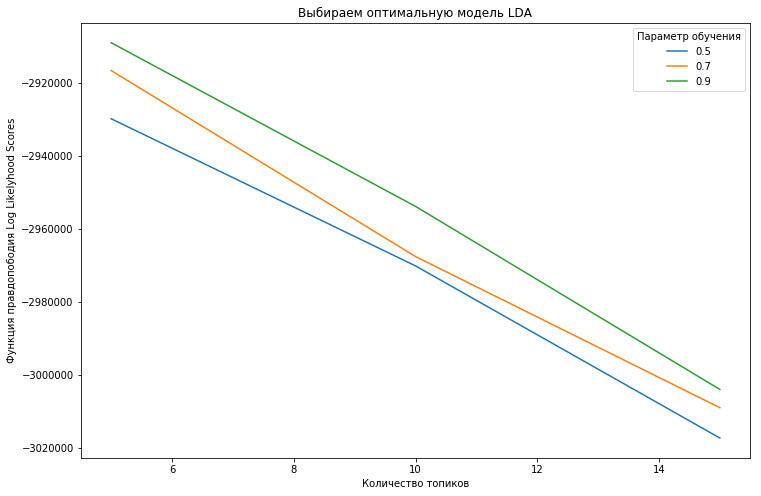

In [106]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Выбираем оптимальную модель LDA")
plt.xlabel("Количество топиков")
plt.ylabel("Функция правдопободия Log Likelyhood Scores")
plt.legend(title='Параметр обучения', loc='best')
plt.show()

Давайте проанализируем графики. По вертикальной оси у нас значения функции правдоподобия. По горизионтальной количество топиков. Максимальное значение мы имеем при количестве топиков 5 и при параметре обучения 0.9. Как раз это нам и сказал Grid Search. Модели с 0.7 и 0.5 достаточно близки к другу другу.

Если не знать точного количество топиков (как в нашем случае), то GridSearch может стать хорошим помощником в этом деле и его результатам стоит доверять.

Теперь выведем топики, которые наша самая лучшая модель нашла.

Напишем сначала функцию, которая нам будет красиво выводить название топика и примерный текст, по которому мы сможем определить категорию.

Стоить отметить что она НЕ скажет вам название категории. Только человек, посмотрев на получившийся текст можно для классифицировать название топика.

In [107]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

Выведем наши топики

In [108]:
# Количество слов, которое мы хотим вывести для каждого топика
n_top_words = 40

print("\nTopics в модели LDA: ")

# Получаем топики
tf_feature_names = count_vectorizer_r.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)


Topics в модели LDA: 

Topic #0:trump clinton said campaign republican new president party people sanders state obama like percent voters just republicans political time democratic presidential cruz bush states gop hillary going candidate house election donald think debate don vote democrats rubio make say american

Topic #1:court marriage law supreme tax health sex said religious states care government davis federal gay workers justice case insurance decision administration obamacare pope issue rights francis state licenses ruling income justices scalia legal pay couples act year people right businesses

Topic #2:said obama iran isis state president military deal islamic people syria security government iraq war united world nuclear attack group foreign house officials al attacks administration forces killed country told states congress paris russia new american syrian news terrorist minister

Topic #3:limbaugh felix unrunning car schweizer gai clown appleberry white demo beer house 

Получилось достаточно хорошо. Например, топик 0 можно определить в категорию "Внутренняя политика/Выборы". Топик 1 в категорию "Права", топик 2 в категорию "Внешняя политика", топик 3 в "Экономика" или "Культура", а топик 4 в категорию "Проишествия/Преступления". Все это сугубо предположения, но все же каждая категория отличается друг от друга.

### Получаем топ 15 слов на каждый топик

Давайте посмотрим на 15 самых встречающихся слов в каждом топике. Это полезно для понимания почему какой-либо текст мог попасть в один из топиков и для наглядного сравнения их друг с другом.

Создадим следующую функцию, в которую мы передаем нашу модель, векторайзер с помощью которого мы делали токенезацию текста и количество слов, которое мы хотим получить.

In [109]:
def show_topics(vectorizer=count_vectorizer_r, lda_model=lda_model, n_words=20):
    # получили топ слов из векторайзера
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

Создадим ДатаФрейм с колонками из слов и строками из топиков

In [110]:
topic_keywords = show_topics(vectorizer=count_vectorizer_r, lda_model=best_lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,trump,clinton,said,campaign,republican,new,president,party,people,sanders,state,obama,like,percent,voters
Topic 1,court,marriage,law,supreme,tax,health,sex,said,religious,states,care,government,davis,federal,gay
Topic 2,said,obama,iran,isis,state,president,military,deal,islamic,people,syria,security,government,iraq,war
Topic 3,limbaugh,felix,unrunning,car,schweizer,gai,clown,appleberry,white,demo,beer,house,want,cancer,easter
Topic 4,said,police,people,department,state,year,black,clinton,law,gun,officers,federal,city,told,new


###  Как мы можем предсказывать топик новым текстам

Наша модель уже натренирована и мы можем давать ей новые тексты, которым она присвоит один из ранее определенных топиков. В идеальном случае она это сделает верно, при условии что и разметка топиков прошла успешно. У нас есть тестовые данные, на которых можно проверить нашу модель.

Дадим натреннированной модели наши тестовые данные

In [111]:
topic_probability_scores = best_lda_model.transform(count_test_r)

Выведем получившиеся оценки

In [311]:
print(topic_probability_scores)

[[1.30090457e-03 1.21982830e-04 5.07450753e-02 1.21829120e-04
  9.47710208e-01]
 [6.37101377e-04 3.71409298e-03 3.23409705e-02 6.35720081e-04
  9.62672115e-01]
 [1.55309442e-02 4.86133668e-04 2.90270438e-01 5.92071440e-03
  6.87791770e-01]
 ...
 [3.81616918e-04 3.75694712e-04 4.49409471e-01 3.75904603e-04
  5.49457312e-01]
 [1.53283309e-04 1.67187237e-04 9.41108826e-01 1.54854288e-04
  5.84158494e-02]
 [8.61834463e-04 8.55150308e-04 9.96543943e-01 8.57360812e-04
  8.81711351e-04]]


Как мы видим для каждой новости из тестовой выборки, модель возвращает 5 чисел, которые соответствуют насколько данная новость попадает в один из топиков. Выбираем максимум в каждом ряду и получаем топик к которому данная новость ближе всего.

Давайте построим функцию, которая будет выводить присвоенный топик и текст новости

In [112]:
def get_topic_text(topic,i):
    print(f"Новость {i} попадает в {topic}-ый Топик\n")
    print(X_test_r.values[i])
    print("-"*30)

Теперь пройдемся по каждой строчке и выберем на ней максимальный элемент. Для выделения индекса максимального элемента в строке воспользуемся функцией argmax из модуля numpy. В нашем случае индексы и будет соответствовать номеру топика. Выведем первые 5 новостей для тестирования.

In [113]:
for i in range(5):
    get_topic_text((np.argmax(topic_probability_scores[i])),i)

Новость 0 попадает в 0-ый Топик

Donald Trump has dominated the GOP presidential race for seven months. Nothing — not his many offensive comments, not his mediocre debate performances, and not the once-feared GOP establishment — has been able to stop his rise.

But on February 1, all that could change when Trump faces by far his biggest challenge yet: the Iowa caucuses.

The results in Iowa — the first time a state's actual voters weigh in in the presidential nomination contest — can make the national contest turn on a dime. Barack Obama won Iowa in 2008, and he suddenly shot up to become competitive with Hillary Clinton in national polls. John Kerry came out of nowhere to win Iowa in 2004, and the presumed leader, Howard Dean, collapsed with astonishing speed.

And Trump could be vulnerable in Iowa. He has taken the lead in recent polls, but there have been anecdotal reports suggesting that Trump's ground game — crucial in the low-turnout caucuses — is laughably inferior to Ted Cruz

Проанализируйте тексты и подумайте, насколько точно они соотвествуют присвоенным топикам

### Wordcount

Визуализируем наши топики Облаком слов (Wordcount). Для этого нужно сначала установить саму библиотеку "!pip install wordcount"

In [114]:
!pip install wordcloud

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Для каждого топика извлечем его компоненты. Атрибут components возвращает количество раз слово j было "назначено" топику i. По факту это таблица components_[i, j]. Мы возвращаем для каждого топика сколько раз каждое слова были отнесено к нему.

In [116]:
first_topic = best_lda_model.components_[0]
second_topic = best_lda_model.components_[1]
third_topic = best_lda_model.components_[2]
fourth_topic = best_lda_model.components_[3]
fifth_topic = best_lda_model.components_[4]

Посмотрим на количество слов в каждой компоненте

In [117]:
first_topic.shape

(37819,)

Соответсвенно имеем 37819 слов, у каждого из которых есть количество попадания в конкретный топик.

Отсортируем в порядке убывания наши слова. Сначала получил особенности


In [118]:
tf_feature_names = count_vectorizer_r.get_feature_names()

Сортируем 50 слов для каждого топика

In [119]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]
fifth_topic_words = [tf_feature_names[i] for i in fifth_topic.argsort()[:-50 - 1 :-1]]

Импортируем сам модуль WordCount и модуль для рисования mathplotlib. WordCount только генерирует текст, который еще нужно нарисовать.

In [120]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Инициализируем объект WordCloud нашими словами из первого топика

In [121]:
firstcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words)) # передаем слова

Рисуем на графике получившийся облако

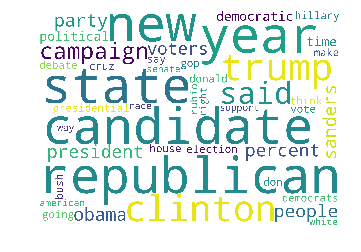

In [122]:
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

Построим аналгичное для всех остальных топиков

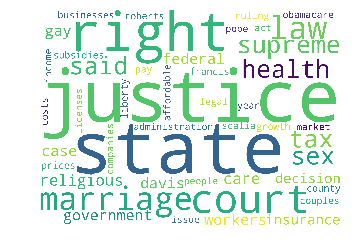

In [123]:
secondcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words)) # передаем слова

plt.imshow(secondcloud)
plt.axis('off')
plt.show()

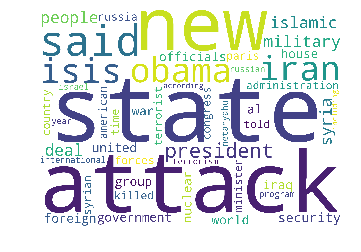

In [124]:
thirdcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words)) # передаем слова

plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

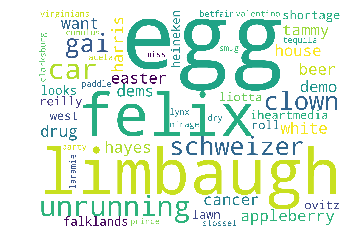

In [125]:
fourthcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words)) # передаем слова

plt.imshow(fourthcloud)
plt.axis('off')
plt.show()

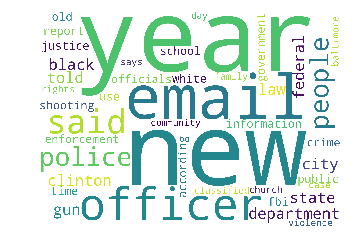

In [126]:
fifthcloud = WordCloud(
                          background_color='white', # Цвет фона
                          width=2500,
                          height=1800
                         ).generate(" ".join(fifth_topic_words)) # передаем слова

plt.imshow(fifthcloud)
plt.axis('off')
plt.show()